<a href="https://colab.research.google.com/github/SaadatTariq/CSE-445/blob/main/Road_Traffic_Accident_Analysis_Injury_Type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

# Loading the dataset


In [ ]:
data = pd.read_excel('/content/RTA Data 2020 to July 2023.xlsx', engine='openpyxl')
data.head()

,EcYear,EcNumber,CallTime,EmergencyArea,TotalPatientsInEmergency,Gender,Age,HospitalName,Reason,responsetime,...,BikesInvolved,BusesInvolved,CarsInvolved,CartInvovled,RickshawsInvolved,TractorInvovled,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved
0,2020,31486,2020-12-31 22:41:47,NEAR APS SCHOOL FORT ROAD RWP,1,Male,27.0,BBH,Bike Slip,10.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,31485,2020-12-31 22:25:00,"Infront of Daig.com, Near Dha gate 2, gt road...",1,Male,20.0,NaN,Car hit Footpath,12.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,31483,2020-12-31 21:54:59,Muhammadi chowk arshad bakery khyaban e sirsye...,1,Male,48.0,BBH,Rickshaw hit with Car,10.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2020,31482,2020-12-31 21:24:22,"Gulzar e quaid, T/W Katcheri Near Attock Pump,...",1,Male,45.0,NaN,Car hit Car and runaway,5.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020,31479,2020-12-31 21:03:49,Taaj Company Gawalmandi Chowk Liaqat Baag Road...,1,Male,22.0,NaN,Unknown Bike hit Bike and runaway,5.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Applying pre-processing from previous submission.


In [ ]:
unique_injury_types = data['InjuryType'].unique()
num_injury_types = data['InjuryType'].nunique()

print("Unique Injury Types:", unique_injury_types)
print("Number of Injury Types:", num_injury_types)

data[['CallTime', 'EcNumber']] = data[['CallTime', 'EcNumber']].ffill()

data = data.drop(index=[41936, 31355, 31356, 21460, 27600, 29371, 33184])

label_encoder = LabelEncoder()
ordinal_encoder_education = OrdinalEncoder(categories=[['PHD', 'Masters', 'Graduation', 'Intermediate',
                                                        'Matric', 'Middle', 'Primary', 'Illetrate']])

data['Gender'] = label_encoder.fit_transform(data['Gender'].astype(str))
data['Cause'] = label_encoder.fit_transform(data['Cause'].astype(str))
data['InjuryType'] = label_encoder.fit_transform(data['InjuryType'].astype(str))
data['EducationTitle'] = ordinal_encoder_education.fit_transform(data[['EducationTitle']])

data.drop(columns=['HospitalName', 'EmergencyArea', 'Reason'], inplace=True)

data['CallTime'] = data['CallTime'].astype(str)
data[['Date', 'Time']] = data['CallTime'].str.split(' ', expand=True)
time_split = data['Time'].str.split(':', expand=True).astype(int)
data['Time(s)'] = time_split[0] * 3600 + time_split[1] * 60 + time_split[2]
data['Time(s)'] = data['Time(s)'] / data['Time(s)'].max()

data.drop(columns=['CallTime', 'Time'], inplace=True)
date_split = data['Date'].str.split('-', expand=True).astype(int)
data['Month'] = date_split[1]
data['Date'] = date_split[2]
data['Age'] = data['Age'] / data['Age'].max()

Unique Injury Types: ['Minor' 'Single Fracture' 'Head Injury' 'Multiple Fractures'
 'Spinal Injury' nan]
Number of Injury Types: 5


#Setting the target InjuryType

In [ ]:
X = data.drop(columns=['InjuryType'])  # Features
y_injury = data['InjuryType']  # Target

label_encoder = LabelEncoder()

non_numeric_cols = X.select_dtypes(include=['object']).columns

for col in non_numeric_cols:
    X[col] = label_encoder.fit_transform(X[col])

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train_injury, X_test_injury, y_train_injury, y_test_injury = train_test_split(
    X, y_injury, test_size=0.2, random_state=42
)

print("Train set size:", X_train_injury.shape)
print("Test set size:", X_test_injury.shape)

Train set size: (36945, 23)
Test set size: (9237, 23)


#Model Training and Evaluation

Model Performance Metrics:
| Metric        | Score   |
|:--------------|:--------|
| Accuracy (%)  | 75.77%  |
| Precision (%) | 65.95%  |
| Recall (%)    | 75.77%  |
| F1 Score (%)  | 66.18%  |


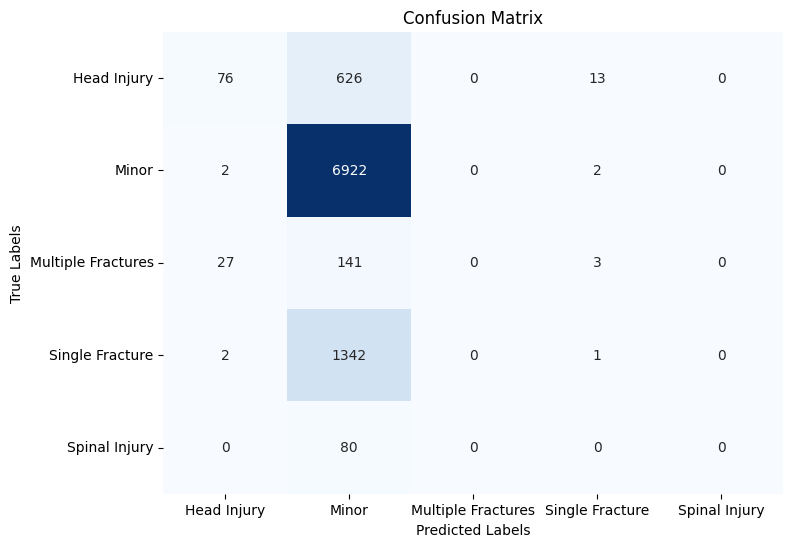

In [ ]:
class_names = ["Head Injury", "Minor", "Multiple Fractures", "Single Fracture", "Spinal Injury"]

def train_evaluate_logistic(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=100, solver='liblinear', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = round(precision_score(y_test, y_pred, average='weighted', zero_division=1) * 100, 2)
    recall = round(recall_score(y_test, y_pred, average='weighted') * 100, 2)
    f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)

    metrics_df = pd.DataFrame({
        "Metric": ["Accuracy (%)", "Precision (%)", "Recall (%)", "F1 Score (%)"],
        "Score": [f"{accuracy}%", f"{precision}%", f"{recall}%", f"{f1}%"]
    })

    print("Model Performance Metrics:")
    print(metrics_df.to_markdown(index=False))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, conf_matrix, precision, recall, f1

injury_metrics = train_evaluate_logistic(X_train_injury, X_test_injury, y_train_injury, y_test_injury)

#Learning Curves for InjuryType

In [ ]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
max_iters = [50, 100, 150, 200, 250, 300, 500]  # Increased max_iter range to handle convergence

def accuracy_vs_solvers(X_train, X_test, y_train, y_test):
    accuracies = []
    for solver in solvers:
        model = LogisticRegression(max_iter=500, solver=solver, random_state=42)  # Set a higher max_iter
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return accuracies

def accuracy_vs_max_iter(X_train, X_test, y_train, y_test):
    accuracies = []
    for max_iter in max_iters:
        model = LogisticRegression(max_iter=max_iter, solver='liblinear', random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return accuracies

#Plot Learning Curves for InjuryType


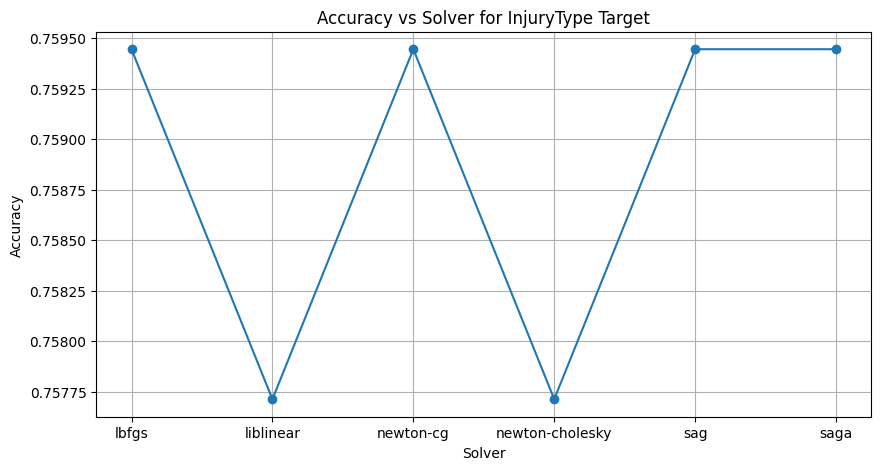

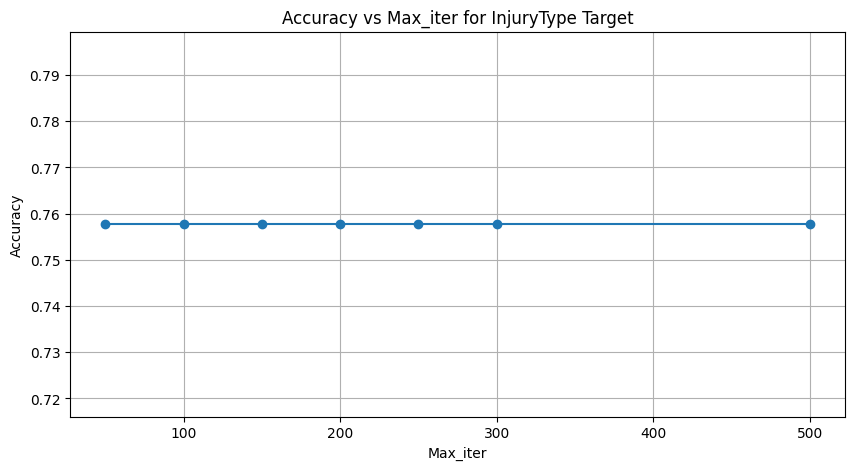

In [ ]:
injury_accuracies_solvers = accuracy_vs_solvers(X_train_injury, X_test_injury, y_train_injury, y_test_injury)
plt.figure(figsize=(10, 5))
plt.plot(solvers, injury_accuracies_solvers, marker='o')
plt.xlabel("Solver")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Solver for InjuryType Target")
plt.grid()
plt.show()

injury_accuracies_iters = accuracy_vs_max_iter(X_train_injury, X_test_injury, y_train_injury, y_test_injury)
plt.figure(figsize=(10, 5))
plt.plot(max_iters, injury_accuracies_iters, marker='o')
plt.xlabel("Max_iter")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max_iter for InjuryType Target")
plt.grid()
plt.show()
